/opt/conda/envs/km310env/lib/python3.10/site-packages/cupyx/jit/_interface.py:173: FutureWarning: cupyx.jit.rawkernel is experimental. The interface can change in the future.
  cupy._util.experimental('cupyx.jit.rawkernel')


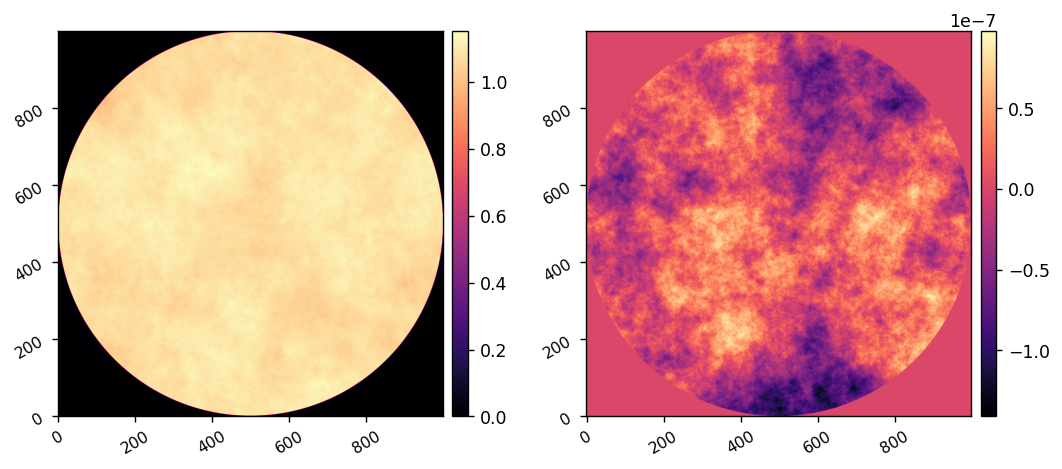

In [1]:
import numpy as np
import astropy.units as u
from astropy.io import fits
import copy
import matplotlib.pyplot as plt
from matplotlib.patches import Circle, Rectangle
from importlib import reload

from scipy.optimize import minimize

from adefc_vortex.math_module import xp, xcipy, ensure_np_array
from adefc_vortex import utils
from adefc_vortex.imshows import imshow1, imshow2, imshow3, plot_data
from adefc_vortex import dm
from adefc_vortex import props
from adefc_vortex import aefc_1dm as adefc
import adefc_vortex.scoob_model as scoobm

wavelength_c = 633e-9

wfe_amp = utils.load_fits('data/example_wfe_amp.fits')
wfe_opd = utils.load_fits('data/example_wfe_opd.fits')
imshow2(wfe_amp, wfe_opd)

# wfe_amp = utils.load_fits('data/pr_est_amp.fits')
# wfe_opd = utils.load_fits('data/pr_est_opd.fits')
# imshow2(wfe_amp, wfe_opd)



# Test the forward model parameters.

Oversampling > 2x suggested for reliable results in Fresnel propagation.


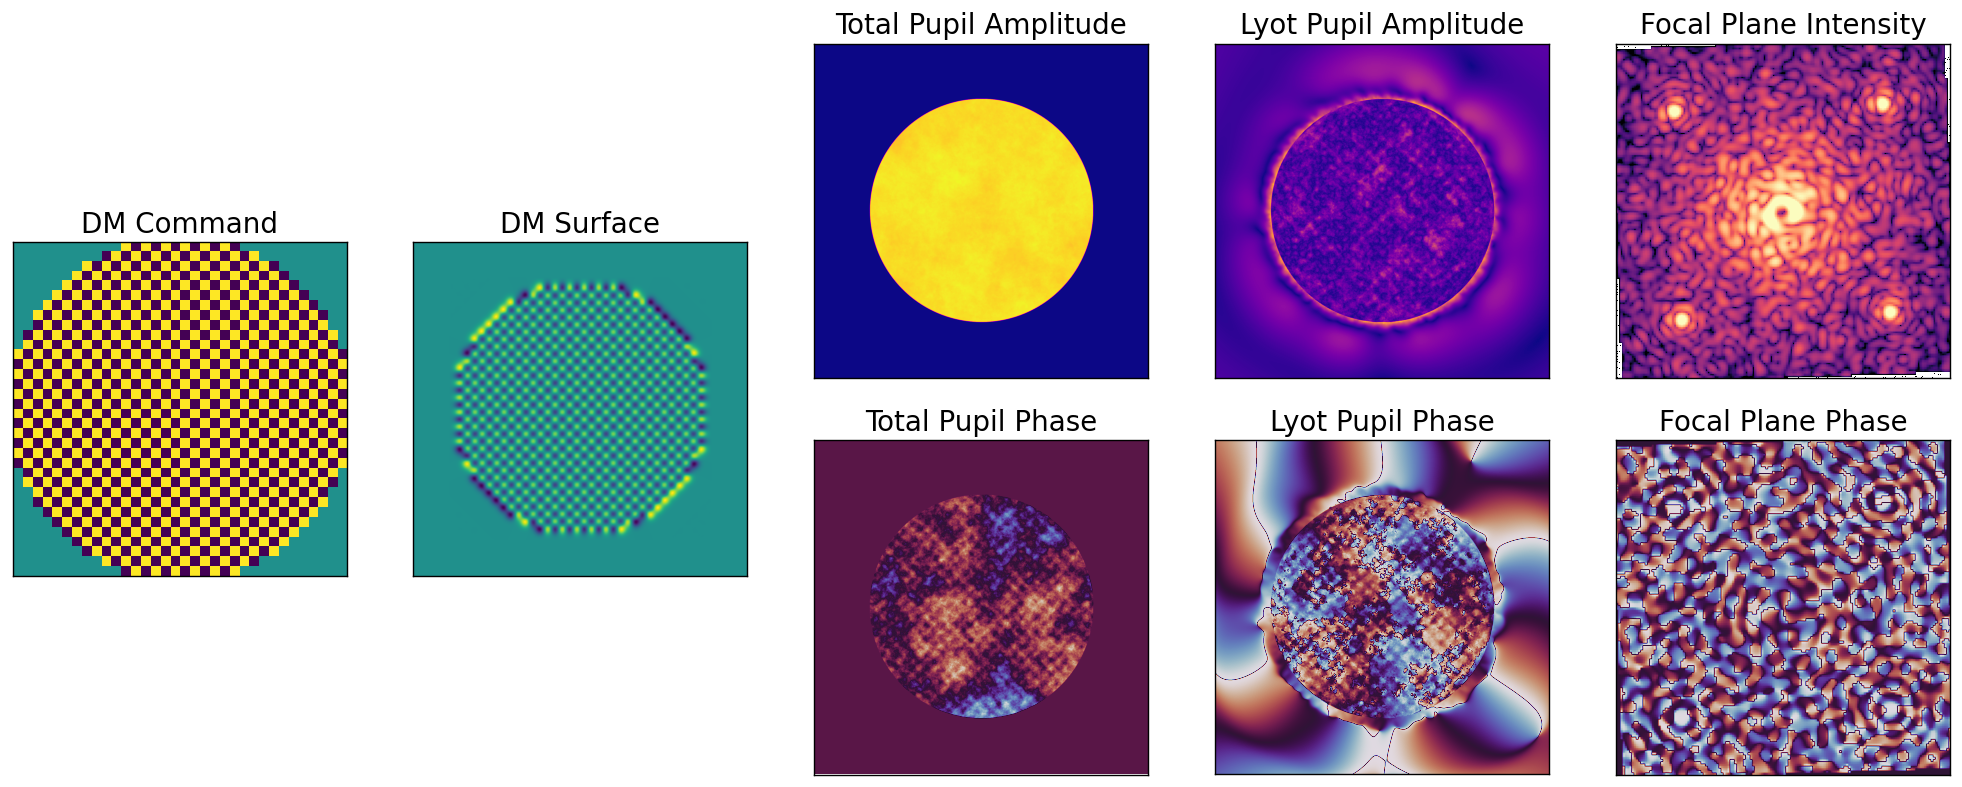

In [2]:
reload(scoobm)
reload(utils)
M = scoobm.MODEL(
    # dm_beam_diam=9.4*u.mm, 
    # lyot_pupil_diam=9.4*u.mm,
    # dm_shift=np.array([0,0])*u.mm,
    # lyot_shift=np.array([0,0.3])*u.mm,
)
M.AMP = wfe_amp
M.OPD = wfe_opd

M.reverse_lyot = 1
M.flip_lyot = 1
M.det_rotation = 178

M.setattr('use_vortex', False)
ref_psf = M.snap()
M.setattr('Imax_ref', xp.max(ref_psf))

command = np.zeros((M.Nact, M.Nact))
command = 30e-9*utils.make_f(h=10, w=6, shift=(0,0))
command = 20e-9*utils.make_fourier_command(x_cpa=17, y_cpa=17)
# fpwf = M.forward(acts, use_vortex=0, plot=True)
fpwf = M.forward(
    command[M.dm_mask], 
    use_vortex=1, 
    plot=0, 
    fancy_plot=1, 
    # fancy_plot_fname='../figs/forward_model.pdf',
)


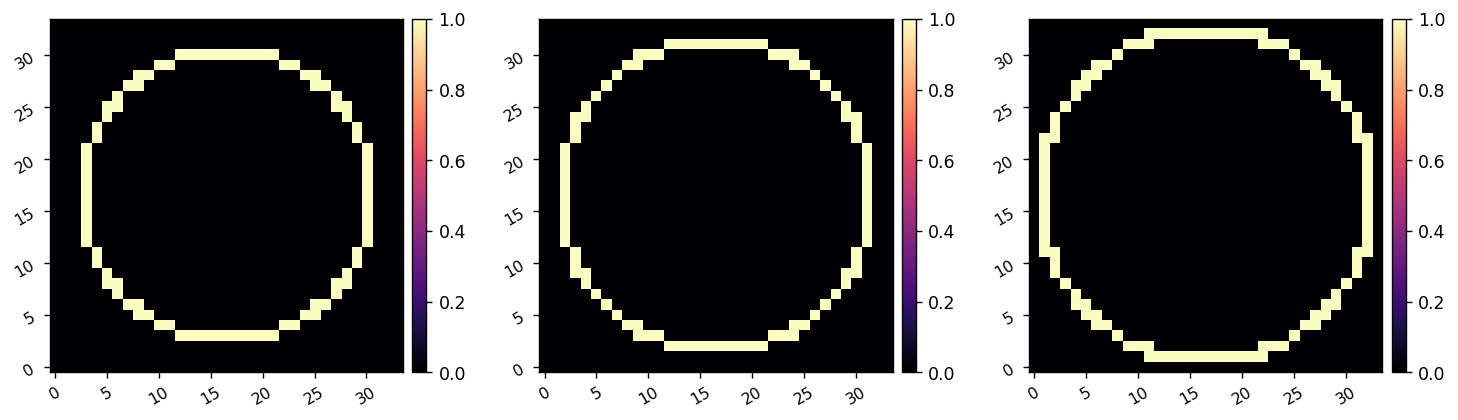

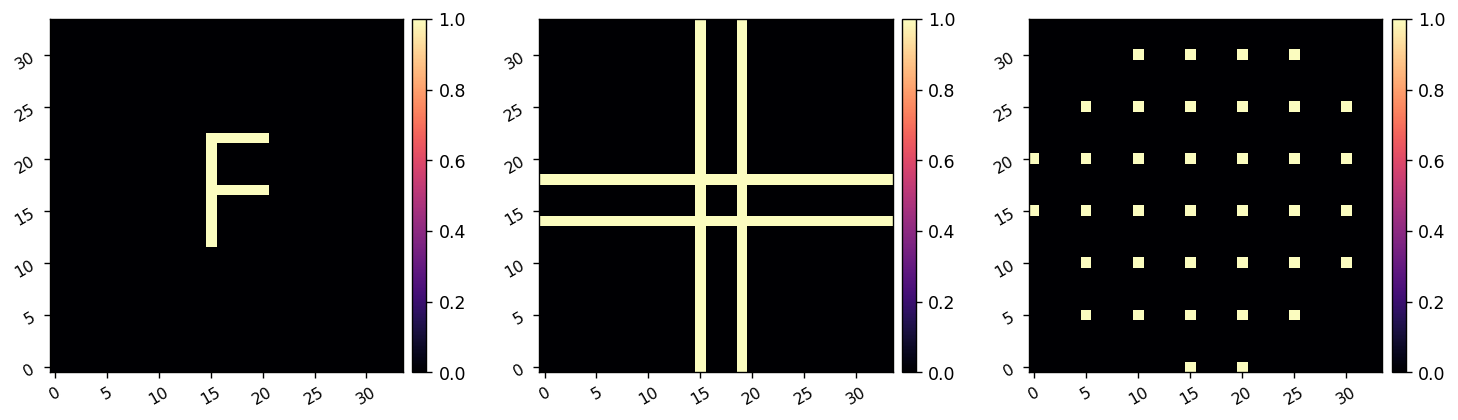

In [3]:
import lina

reload(lina.utils)

ring_13 = lina.utils.make_ring(rad=13, Nact=34)
ring_14 = lina.utils.make_ring(rad=14, Nact=34)
ring_15 = lina.utils.make_ring(rad=15, Nact=34)
ring_16 = lina.utils.make_ring(rad=16, Nact=34)
f = lina.utils.make_f()
imshow3(ring_14, ring_15, ring_16)

cross = lina.utils.make_cross_command(xc=[-1, 3], yc=[2,-2])

pokes = xp.zeros((34,34))
for i in range(34):
    for j in range(34):
        if i%5==0 and j%5==0:
            pokes[i,j] = 1
pokes *= M.dm_mask
imshow3(f, cross, pokes)

Oversampling > 2x suggested for reliable results in Fresnel propagation.


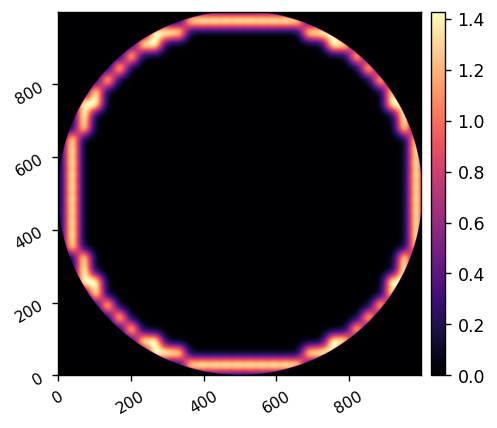

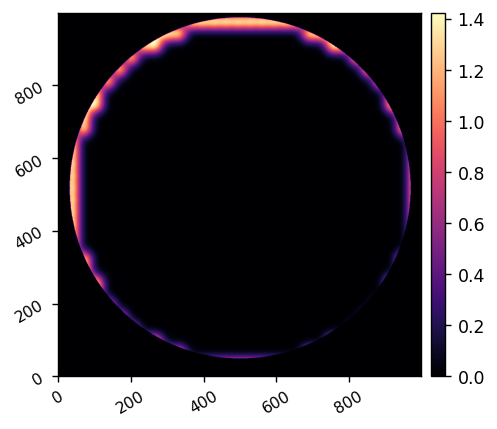

In [8]:
reload(scoobm)
reload(utils)
M = scoobm.MODEL(
    dm_beam_diam=9.2*u.mm, 
    lyot_pupil_diam=9.2*u.mm,
    dm_shift=np.array([0.1,0.0])*u.mm,
    lyot_shift=np.array([0.0,0.15])*u.mm,
    # lyot_shift=np.array([-0.1,0.2])*u.mm,
)
# M.AMP = wfe_amp
# M.OPD = wfe_opd/10

# M.reverse_lyot = 1
# M.flip_lyot = 1
# M.det_rotation = 178

M.setattr('use_vortex', False)
ref_psf = M.snap()
M.setattr('Imax_ref', xp.max(ref_psf))

amp = 50e-9
command = xp.zeros((34,34))
command = amp*ring_13
command = amp*ring_14
command = amp*ring_15
# command = amp*ring_16
# command = amp*f
# command = amp*cross
# command = amp*pokes

E_FP, E_EP, DM_PHASOR, E_DM, E_LP, E_LS = M.forward(
    command[M.dm_mask], 
    use_vortex=0, 
    return_ints=1,
)

E_EP = utils.pad_or_crop(E_EP, M.npix)
DM_PHASOR = utils.pad_or_crop(DM_PHASOR, M.npix)
E_DM = utils.pad_or_crop(E_DM, M.npix)
E_LS = utils.pad_or_crop(E_LS, M.npix)

imshow1(xp.angle(E_DM)*M.APERTURE, npix=M.npix)
imshow1(xp.angle(E_LS)*M.APERTURE, npix=M.npix)

Oversampling > 2x suggested for reliable results in Fresnel propagation.


	Cost-function J_delE: 4808.944
	Cost-function J_c: 0.000
	Cost-function normalization factor: 4808.944
	Total cost-function value: 1.000



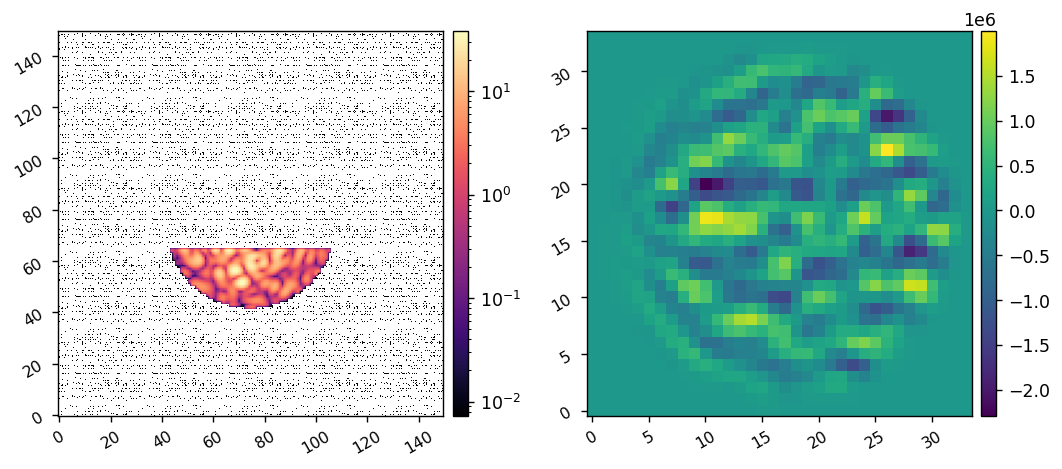

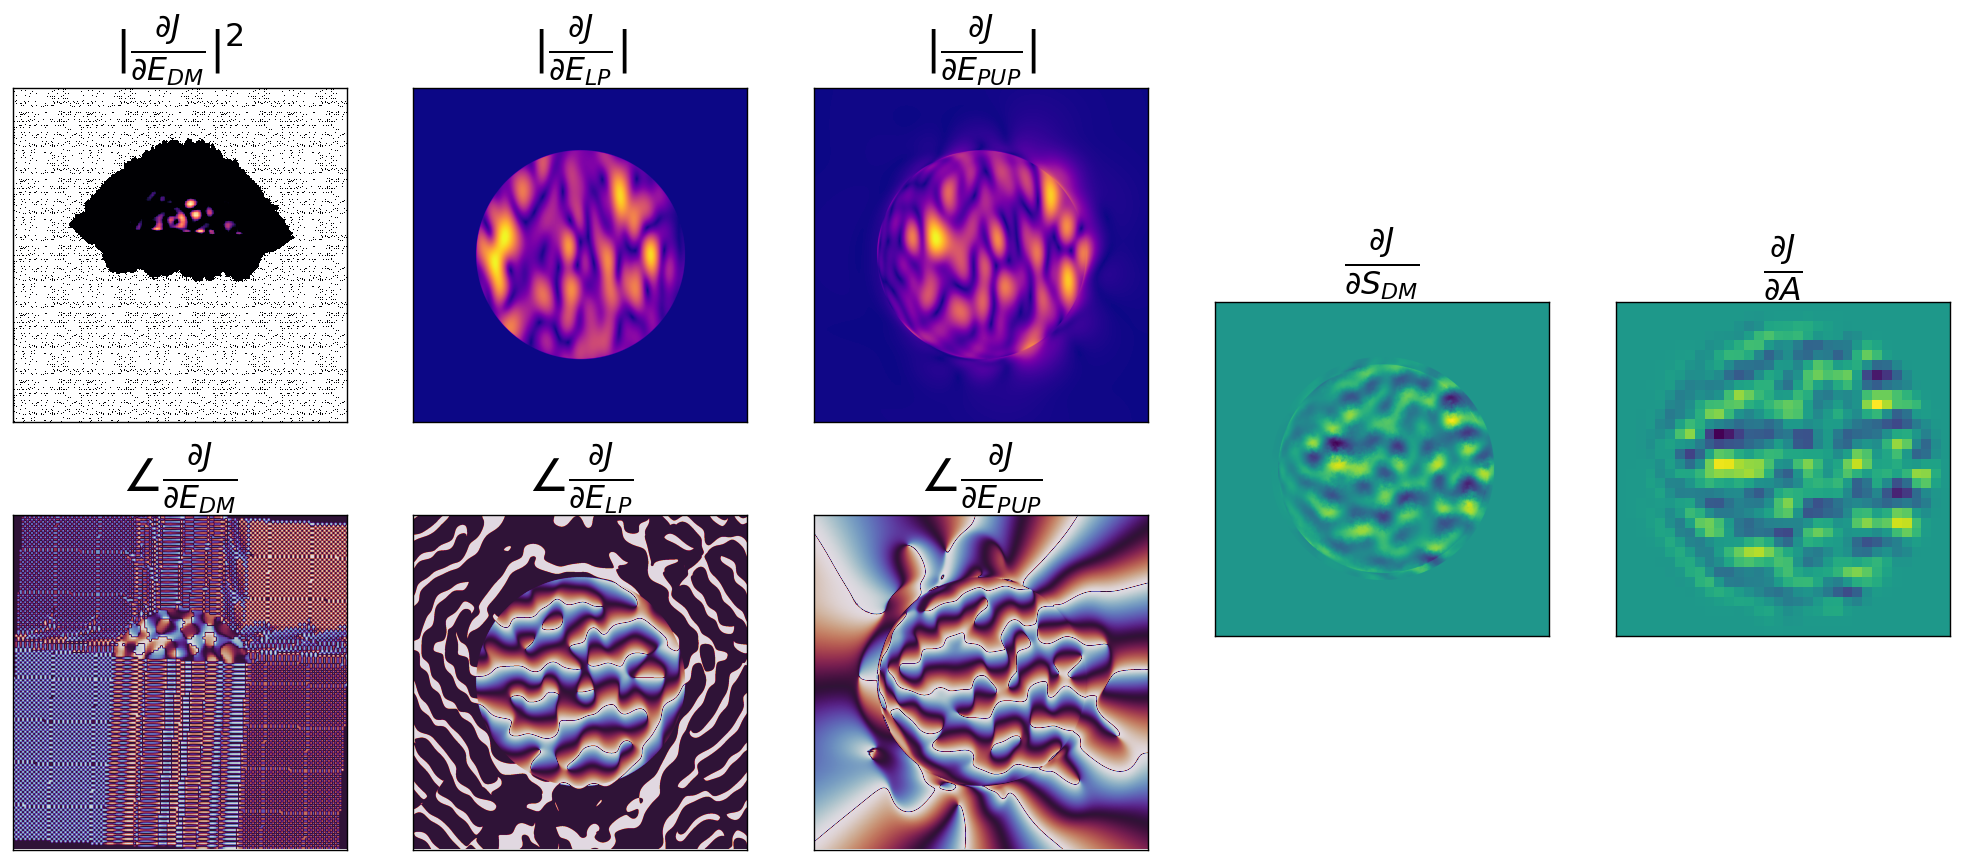

In [70]:
reload(scoobm)

M = scoobm.MODEL(
    # dm_beam_diam=9.4*u.mm, 
    # lyot_pupil_diam=9.4*u.mm,
    # dm_shift=np.array([0.075,0])*u.mm,
    # lyot_shift=np.array([0.0,0.2])*u.mm,
    # lyot_shift=np.array([-0.1,0.2])*u.mm,
)
M.AMP = wfe_amp
M.OPD = wfe_opd

M.reverse_lyot = 1
M.flip_lyot = 1
M.det_rotation = 177

I = copy.deepcopy(M)

current_acts = xp.zeros(M.Nacts)
# current_acts = xp.array(fits.getdata('ad_test_acts.fits'))

iwa = 3
owa = 10
rot = 90
control_mask = utils.create_annular_focal_plane_mask(I.npsf, I.psf_pixelscale_lamDc, irad=iwa, orad=owa, edge=iwa, rotation=rot)

I.set_dm(scoobm.acts_to_command(current_acts, I.dm_mask))
E_ab = I.calc_wf() * control_mask
E_FP_NOM, E_EP, DM_PHASOR, E_DM, E_LP, E_LS = M.forward(current_acts, wavelength=I.wavelength_c, use_vortex=True, return_ints=True)

rmad_params = {
    'E_ab': E_ab,
    'current_acts': current_acts,
    'E_FP_NOM': E_FP_NOM, 
    'E_EP': E_EP, 
    'DM_PHASOR': DM_PHASOR,
    'control_mask': control_mask,
    'wavelength':I.wavelength_c,
    'r_cond': 1e-3, 
}

del_acts = xp.zeros(M.Nacts)
J, dJ_dA = scoobm.val_and_grad(
    del_acts, M, rmad_params, verbose=True, 
    plot=0, fancy_plot=1, 
    # fancy_plot_fname='../figs/adjoint_model.pdf',
)

dm_grad = scoobm.acts_to_command(dJ_dA, M.dm_mask)
imshow2(xp.abs(E_ab)**2, dm_grad, lognorm1=True, cmap2='viridis')

Oversampling > 2x suggested for reliable results in Fresnel propagation.


	Cost-function J_delE: 4861.071
	Cost-function J_c: 0.000
	Cost-function normalization factor: 4861.071
	Total cost-function value: 1.000



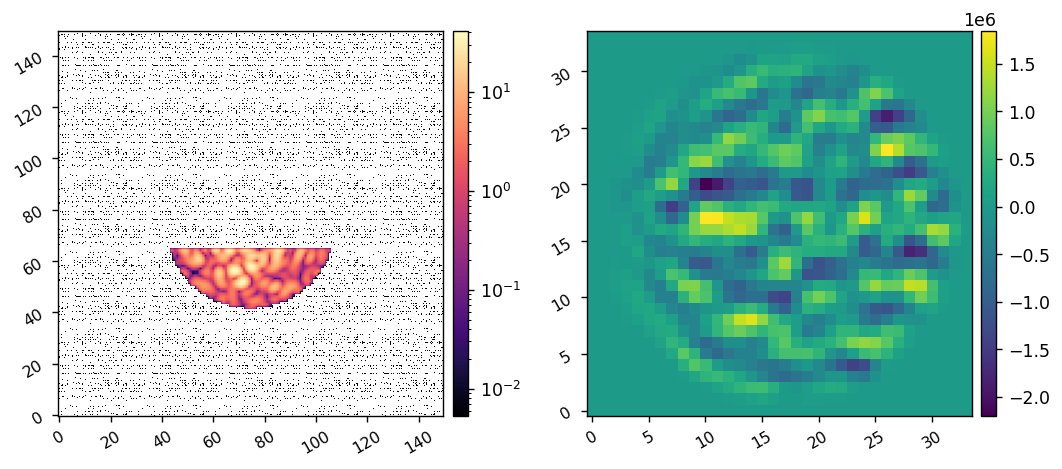

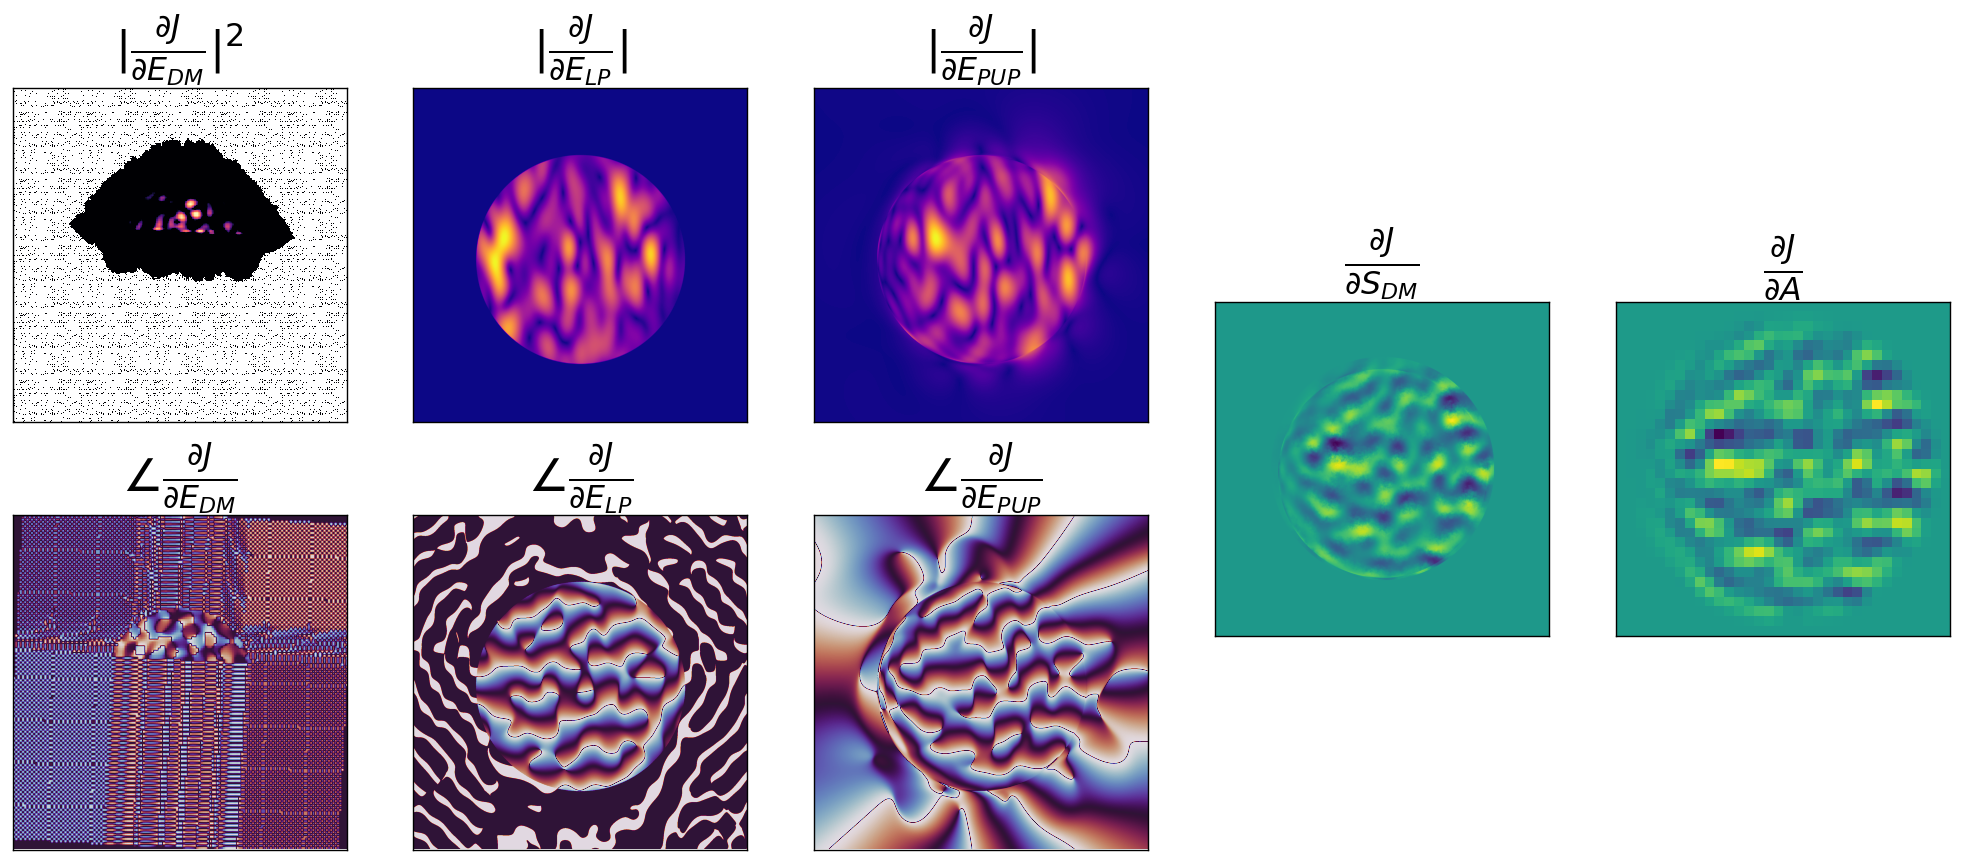

In [71]:
reload(scoobm)

M = scoobm.MODEL(
    # dm_beam_diam=9.4*u.mm, 
    # lyot_pupil_diam=9.4*u.mm,
    dm_shift=np.array([0.15,0])*u.mm,
    lyot_shift=np.array([0.0,0.2])*u.mm,
    # lyot_shift=np.array([-0.1,0.2])*u.mm,
)
M.AMP = wfe_amp
M.OPD = wfe_opd

M.reverse_lyot = 1
M.flip_lyot = 1
M.det_rotation = 177
# M.det_rotation = -90

I = copy.deepcopy(M)

current_acts = xp.zeros(M.Nacts)
# current_acts = xp.array(fits.getdata('ad_test_acts.fits'))

iwa = 3
owa = 10
rot = 90
control_mask = utils.create_annular_focal_plane_mask(I.npsf, I.psf_pixelscale_lamDc, irad=iwa, orad=owa, edge=iwa, rotation=rot)

I.set_dm(scoobm.acts_to_command(current_acts, I.dm_mask))
E_ab = I.calc_wf() * control_mask
E_FP_NOM, E_EP, DM_PHASOR, E_DM, E_LP, E_LS = M.forward(current_acts, wavelength=I.wavelength_c, use_vortex=True, return_ints=True)

rmad_params = {
    'E_ab': E_ab,
    'current_acts': current_acts,
    'E_FP_NOM': E_FP_NOM, 
    'E_EP': E_EP, 
    'DM_PHASOR': DM_PHASOR,
    'control_mask': control_mask,
    'wavelength':I.wavelength_c,
    'r_cond': 1e-3, 
}

del_acts = xp.zeros(M.Nacts)
J, dJ_dA = scoobm.val_and_grad(
    del_acts, M, rmad_params, verbose=True, 
    plot=0, fancy_plot=1, 
    # fancy_plot_fname='../figs/adjoint_model.pdf',
)

dm_grad_shift = scoobm.acts_to_command(dJ_dA, M.dm_mask)
imshow2(xp.abs(E_ab)**2, dm_grad_shift, lognorm1=True, cmap2='viridis')

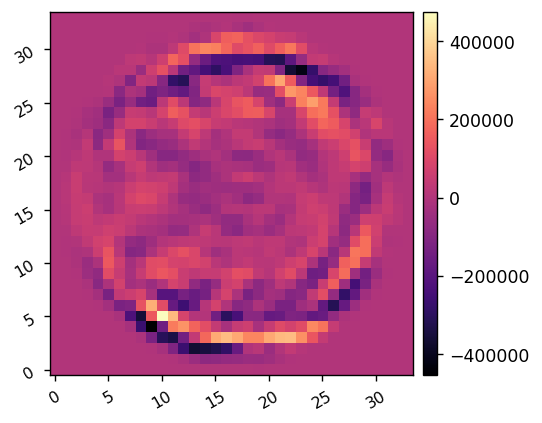

In [69]:
imshow1(dm_grad - dm_grad_shift)